In [2]:
!pip install skforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.5/670.5 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.3 MB/s eta 0:00:00


In [22]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.6 MB/s eta 0:00:00


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from skforecast.ForecasterAutoreg import ForecasterAutoreg
import pmdarima as pmd


from sklearn.metrics import mean_squared_error

In [4]:
df = pd.read_csv('/content/drive/MyDrive/data/df_cleaned.csv')

In [5]:
df_series = df[['total_payment', 'transaction_datetime']]

In [6]:
df_series['transaction_datetime'] = pd.to_datetime(df_series['transaction_datetime'])
df_series['transaction_datetime'] = df_series['transaction_datetime'].sort_values()

<ipython-input-6-2a9adbe14122>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_series['transaction_datetime'] = pd.to_datetime(df_series['transaction_datetime'])
<ipython-input-6-2a9adbe14122>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_series['transaction_datetime'] = df_series['transaction_datetime'].sort_values()


In [7]:
df_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 2 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   total_payment         149116 non-null  float64       
 1   transaction_datetime  149116 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.3 MB


In [8]:
df_series = df_series.set_index('transaction_datetime')

In [9]:
df_series = df_series.groupby(df_series.index)['total_payment'].sum()

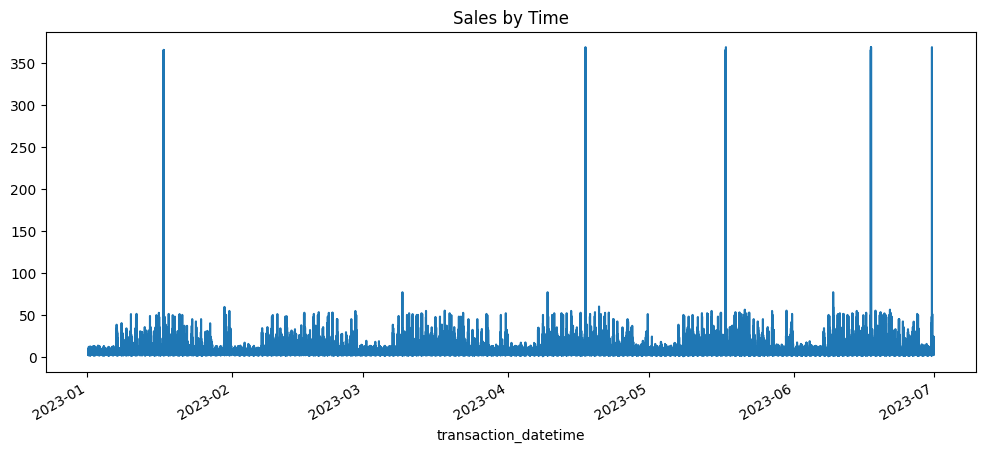

In [10]:
df_series.plot(figsize=(12,5), title='Sales by Time')
plt.show()

In [11]:
daily_sales = df_series.resample('D').sum()

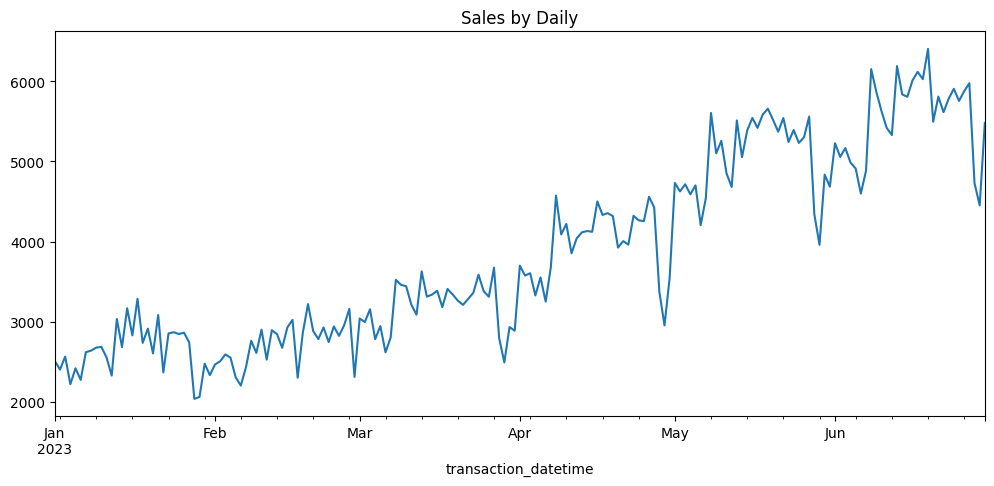

In [12]:
daily_sales.plot(figsize=(12,5), title='Sales by Daily')
plt.show()

## Data Preprocessing

In [13]:
steps = int(len(daily_sales) * 0.2)
train_data = daily_sales[:-steps]
test_data = daily_sales[-steps:]

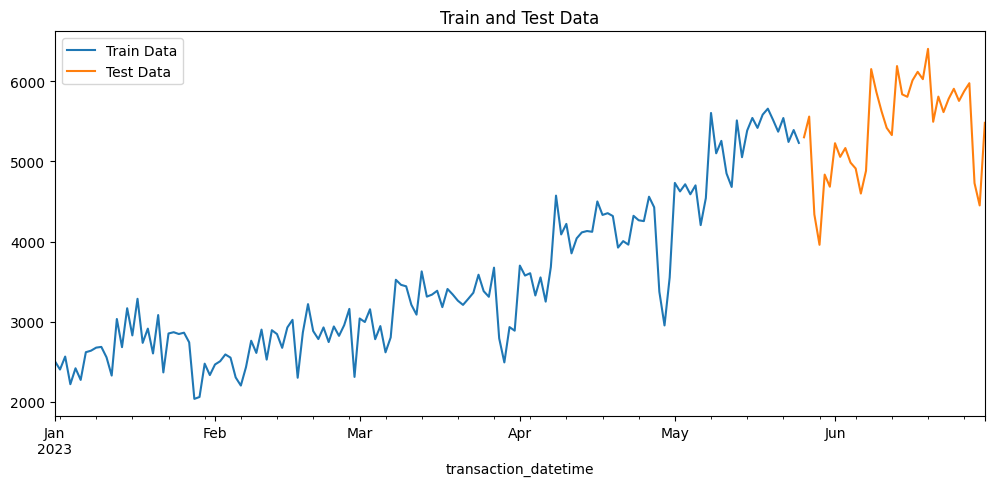

In [14]:
fig,ax =plt.subplots(figsize=(12,5))
train_data.plot(ax=ax, label='Train Data', title='Train and Test Data')
test_data.plot(ax=ax, label='Test Data')
plt.legend()
plt.show()

## Model and Evaluation

### Random Forest Regression

In [35]:
forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(random_state=123),
    lags = 12
)

In [36]:
forecaster.fit(y=train_data)

In [37]:
rf_predictions = forecaster.predict(steps)

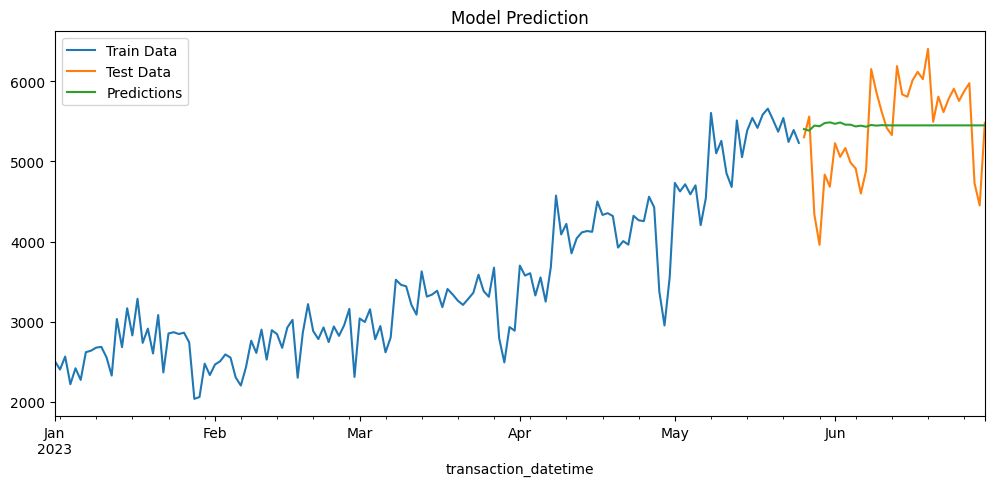

In [38]:
fig,ax =plt.subplots(figsize=(12,5))
train_data.plot(ax=ax, label='Train Data', title='Model Prediction')
test_data.plot(ax=ax, label='Test Data')
rf_predictions.plot(ax=ax, label='Predictions')
plt.legend()
plt.show()

In [39]:
mse_rf = mean_squared_error(y_true = test_data, y_pred=rf_predictions)
print(f'Random Forest MSE = {mse_rf}')

Random Forest MSE = 345749.3291829402


### Linear Regression

In [40]:
forecaster = ForecasterAutoreg(
    regressor = LinearRegression(),
    lags = 12
)

forecaster.fit(y=train_data)

linreg_predictions = forecaster.predict(steps)

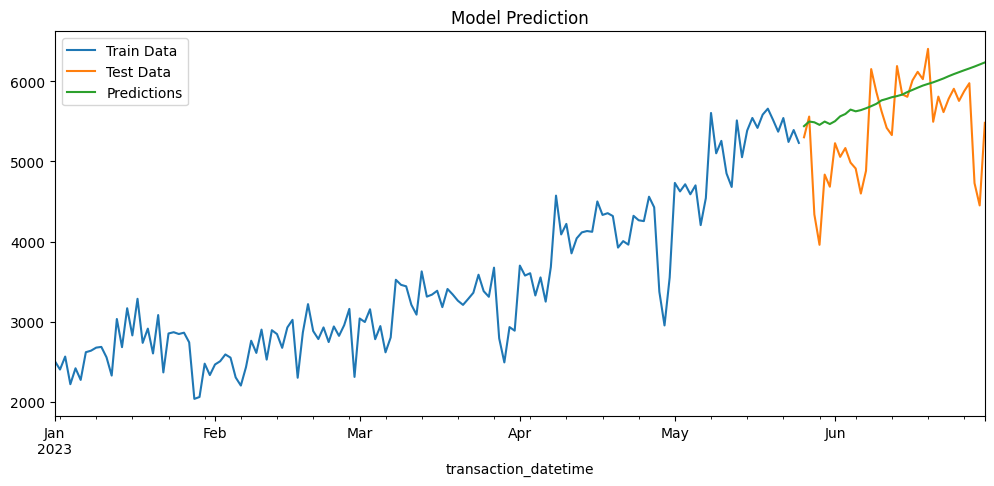

In [41]:
fig,ax =plt.subplots(figsize=(12,5))
train_data.plot(ax=ax, label='Train Data', title='Model Prediction')
test_data.plot(ax=ax, label='Test Data')
linreg_predictions.plot(ax=ax, label='Predictions')
plt.legend()
plt.show()

In [42]:
mse_model = mean_squared_error(y_true = test_data, y_pred=linreg_predictions)
print(f'mse = {mse_model}')

mse = 426807.2245010716


### Arima

In [27]:
arima = pmd.AutoARIMA(seasonal=True)
arima.fit(train_data)

AutoARIMA()

In [28]:
arima_predict = arima.predict(steps)

In [30]:
arima_train_predict = arima.predict_in_sample()

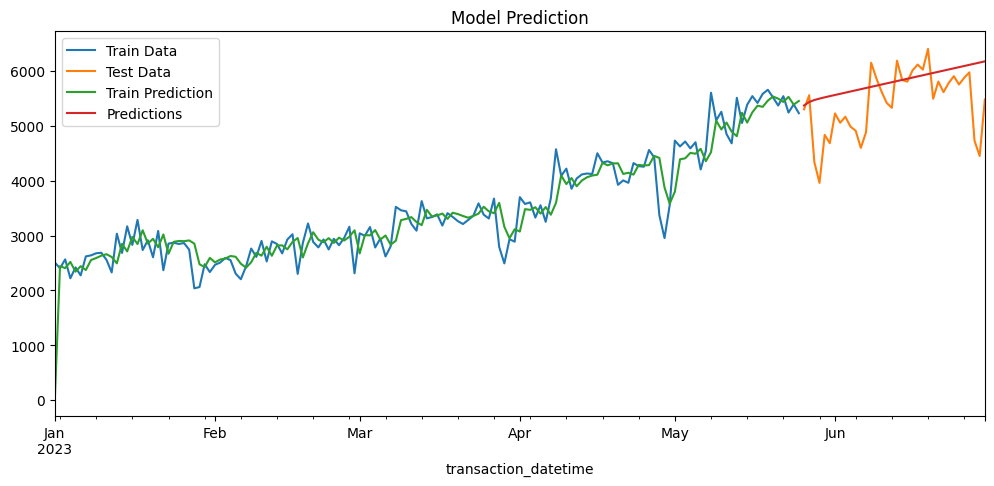

In [31]:
fig,ax =plt.subplots(figsize=(12,5))
train_data.plot(ax=ax, label='Train Data', title='Model Prediction')
test_data.plot(ax=ax, label='Test Data')
arima_train_predict.plot(ax=ax, label='Train Prediction')
arima_predict.plot(ax=ax, label='Predictions')
plt.legend()
plt.show()

In [34]:
mse_arima = mean_squared_error(y_true = test_data, y_pred=arima_predict)
print(f'Arima MSE = {mse_arima}')

Arima MSE = 422905.33886970615
